#### **Task 2**
 1. Perform "Action Recognition" on the KTH-Actions dataset:
    - https://www.csc.kth.se/cvap/actions/
    - https://github.com/tejaskhot/KTH-Dataset
    - Already downloaded in `/home/nfs/inf6/data/datasets/kth_actions`
    - Use spatial dimensionality of frames of 64x64
    - Split videos into subsequences of e.g. 10 frames. Treat each of these subsequences as independent.
    - Feel free to use augmentations (temporal and/or spatial)
    

<br>

2. Implement a model with the following structure:
    - Convolutional encoder (probably more powerful than the one from above)
    - Recurrent module
    - Classifier (probably Conv + AvgPooling/Flattening + Linear)


<br>

3. Train, evaluate, and compare the model with the recurrent modules listed below.<br>
   Compare the models in terms of accuracy, training/inference time, and number of learnable parameters.<br>
   **Log the experiments on Tensorboard/WandB**. <br>
   RNNs to evaluate:
    - PyTorch LSTM model (using nn.LSTMCell)
    - PyTorch GRU model (using nn.GRUCell)
    - Your own LSTM
    - Your own ConvLSTM
    - **Note**: Different recurrent modules (e.g. LSTM vs ConvLSTM) might require slight changes in the encoder and classifier

In [1]:
from utils import *
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import random
import re
from transformations import get_train_transforms,get_test_transforms
from dataloader import KTHActionDataset


In [2]:

# Create datasets
root_dir = "/home/nfs/inf6/data/datasets/kth_actions/processed/"

train_dataset = KTHActionDataset(root_dir, 
                                 split="train", 
                                 transform=get_train_transforms(), 
                                 max_frames=80, 
                                 img_size=(64, 64))

test_dataset = KTHActionDataset(root_dir, 
                                split="test", 
                                transform=get_test_transforms(), 
                                # transform=None,
                                max_frames=80, 
                                img_size=(64, 64))


In [3]:
# train_dataset[2]

### Data Visualization

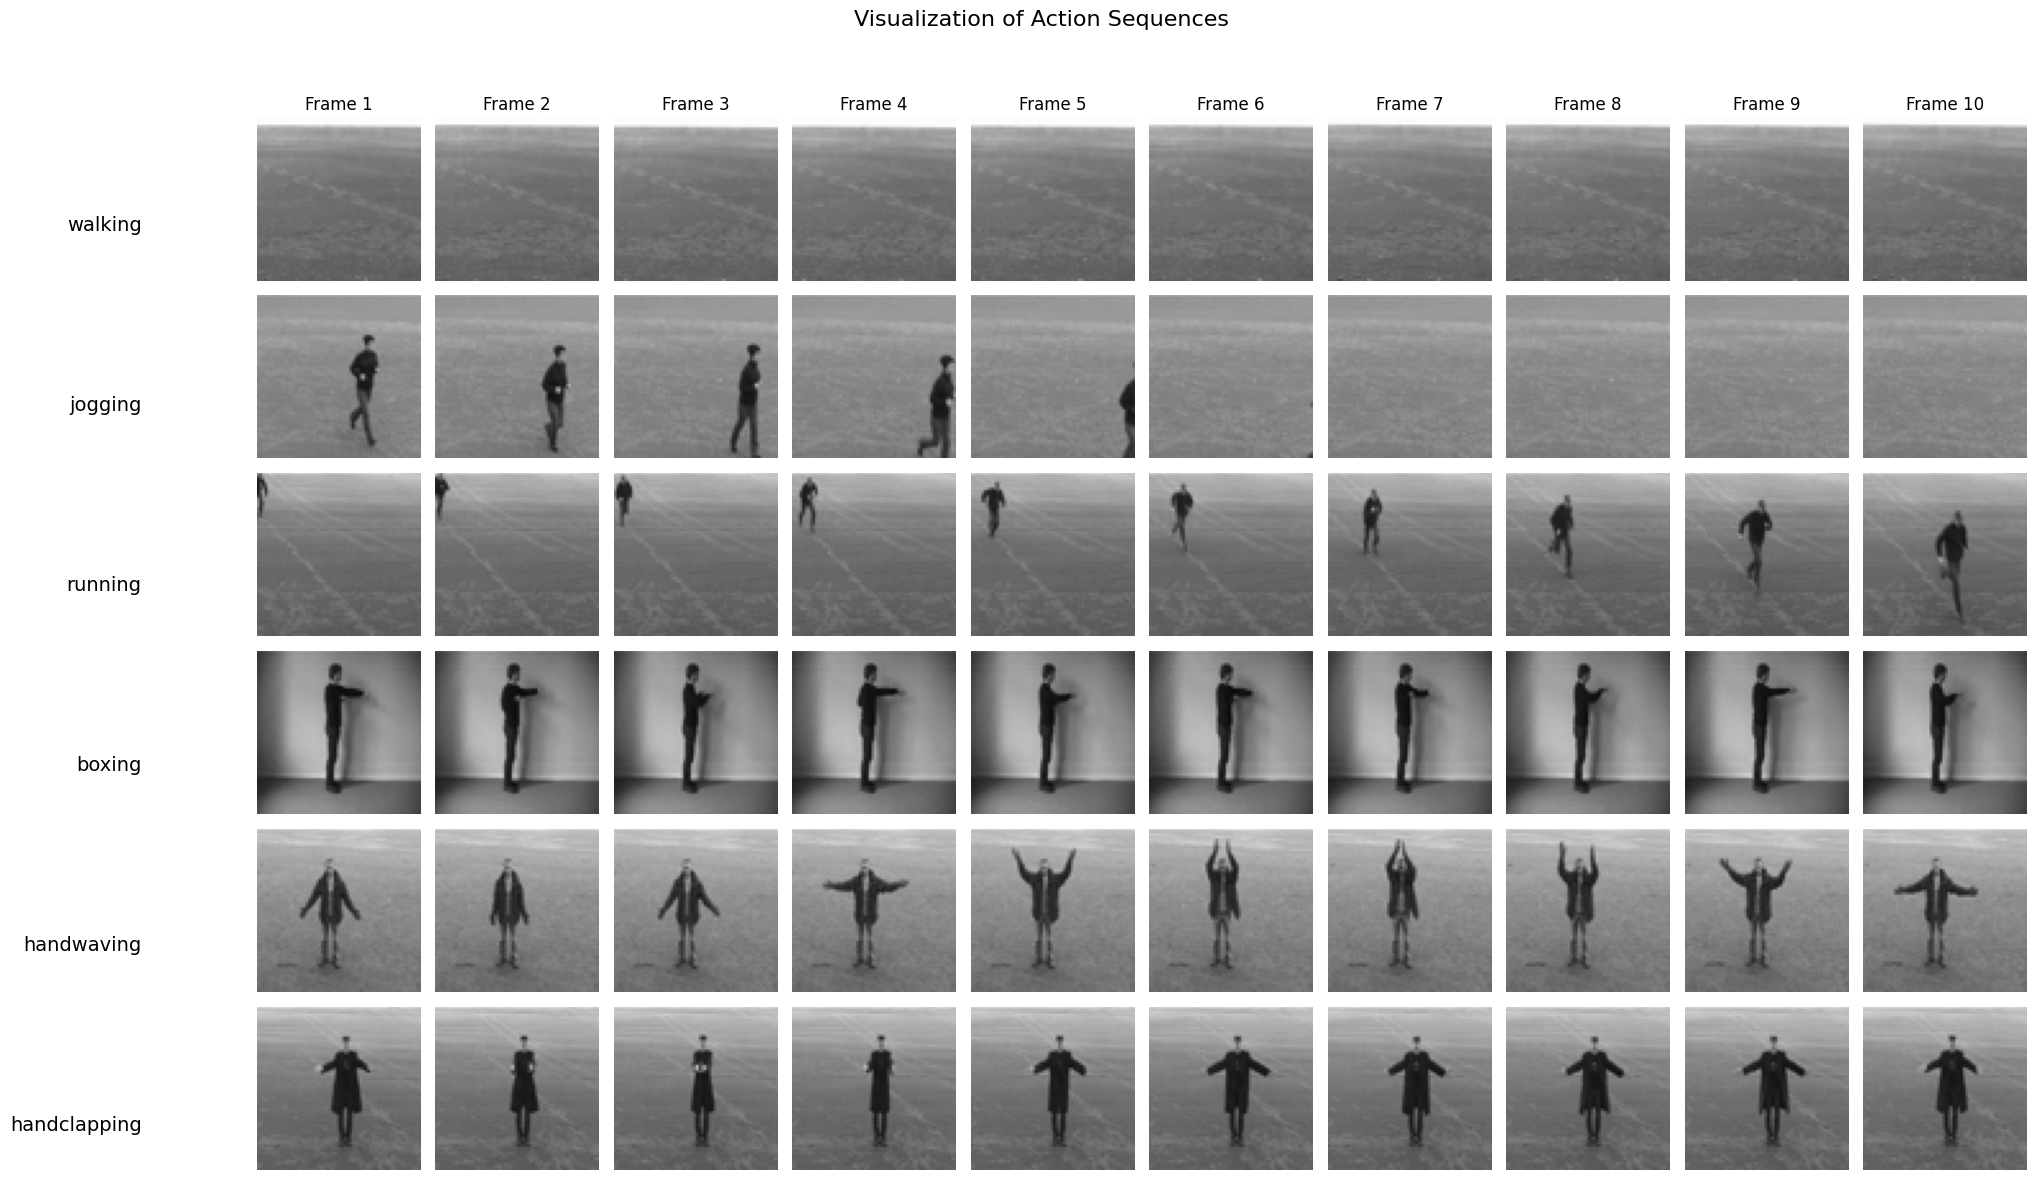

In [4]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

frames, labels = next(iter(test_loader))

unique_labels = np.unique(labels.numpy())
fig, axes = plt.subplots(len(unique_labels), 10, figsize=(20, 12))
fig.suptitle('Visualization of Action Sequences', fontsize=16)

if len(unique_labels) == 1:
    axes = np.expand_dims(axes, axis=0)

categories = ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']

# For each action category in this batch
for i, action_idx in enumerate(unique_labels):
    # Find all samples of this action in the batch
    action_samples = frames[labels == action_idx]
    if len(action_samples) > 0:
        sample = action_samples[0]
        
        for frame_idx in range(10):
            frame = sample[frame_idx].squeeze().cpu().numpy()
   
            axes[i, frame_idx].imshow(frame, cmap='gray', vmin=0, vmax=1)
            axes[i, frame_idx].axis('off')
            
            # Add frame number to the first row
            if i == 0:
                axes[i, frame_idx].set_title(f'Frame {frame_idx+1}')
    
    row_height = 0.9/len(unique_labels)
    row_center = 0.9 - (i * row_height + row_height/2)
    action_name = categories[action_idx.item()]
    
    # Move label down by adding a negative offset to y-coordinate
    vertical_offset = 0.025  # Approximate adjustment for 0.3cm
    fig.text(0.05, row_center - vertical_offset, 
             action_name, 
             fontsize=14, 
             ha='right',
             va='center')

plt.tight_layout(rect=[0.1, 0, 1, 0.95]) 
plt.show()

In [5]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          num_workers=4)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         num_workers=4)

In [6]:
## Verifying the dataloader  
for batch in test_loader:
    frames, labels = batch
    print(f"Batch shape: {frames.shape}, Labels: {labels.shape}")
    break

Batch shape: torch.Size([64, 20, 1, 64, 64]), Labels: torch.Size([64])


In [7]:
def SelectRNN(emb_dim, hidden_dim, num_layers, network : str = 'LSTMCell') -> nn.Module:

    assert network in ("LSTMCell", "GRUCell", "OwnLSTM", "OwnConvLSTM")

    if network == "LSTMCell":
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        RNN = nn.ModuleList(lstms)
        
    elif network == "GRUCell":
        grus = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            grus.append(nn.GRUCell(input_size=in_size, hidden_size=hidden_dim))
        RNN = nn.ModuleList(grus)
    elif network == "OwnLSTM":
        pass
    elif network == "OwnConvLSTM":
        pass
        
    return RNN

In [8]:
class ActionClassifier(nn.Module):

    def __init__(self, emb_dim, hidden_dim, rnn_network, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.rnn_ = rnn_network
        # self.embed_dim = emb_dim
        self.mode = mode
        
        # self.encoder = nn.Sequential(                   # (batch_size, 1(n_channels), H, W)
        #         nn.Conv2d(1, 16, kernel_size=5),  nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),   
        #         nn.Conv2d(16, 32, kernel_size=3), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),  
        #         nn.Conv2d(32, 64, kernel_size=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),  
        #         nn.Conv2d(64, 128,kernel_size=3), nn.BatchNorm2d(128),  nn.ReLU(), nn.MaxPool2d(2),
        #         nn.Conv2d(128, emb_dim, kernel_size=1),               
        #         nn.AdaptiveAvgPool2d((1, 1))    #Averages each channel to a single value.(batch_size, emb_dim, 1, 1)
        #     )

        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1],  # Remove the final fc layer
            nn.Conv2d(512, emb_dim, kernel_size=1),  # Project to desired embedding dimension
            nn.AdaptiveAvgPool2d((1, 1))  # Average pooling to get (batch_size, emb_dim, 1, 1)
        )

        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
        #     nn.MaxPool2d(2),

        #     nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        #     nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        #     nn.MaxPool2d(2),

        #     nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        #     nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        #     nn.MaxPool2d(2),

        #     nn.Conv2d(256, emb_dim, 1),  # project to emb_dim
        #     nn.AdaptiveAvgPool2d((1, 1))
        # )
        
        # RNN model
        self.rnn = SelectRNN(emb_dim= emb_dim , 
                             hidden_dim=self.hidden_dim, 
                             network= self.rnn_, 
                             num_layers= self.num_layers)
        
        
        # Classifier (Conv + AvgPooling + Linear) as described in the assignment
        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=hidden_dim, out_channels=32, kernel_size=3, padding=1), #(batch_size, in_channels, seq_len)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 6)
        )
        # self.classifier = nn.Linear(in_features=hidden_dim, out_features=6)

        # self.classifier = nn.Sequential(
        #     nn.Linear(hidden_dim, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(128, 6)
        # )
        return
    
    # def forward(self, x):
        """ Forward pass through model """
        
        b_size, num_frames, n_channels, H, W = x.shape
        # h, c = self.init_state(b_size=b_size, device=x.device) 
        h_init, c_init = self.init_state(b_size=b_size, device=x.device)
        
        # encoding all images in parallel rows
        x = x.view(b_size * num_frames, n_channels, H, W)
        embeddings = self.encoder(x)  # (b*T, C, H, W)  --> (B * T, emb_dim)
        embeddings = embeddings.reshape(b_size, num_frames, -1) # Again opening up, so that we can feed it to LSTM

        # if self.rnn_ in ["LSTMCell", "GRUCell"]:
        #     rnn_out = []
        #     for i in range(embeddings.shape[1]):  # iterate over time steps. These two for loops will fuck the training speed and our time !
        #         rnn_input = embeddings[:, i, :]  # separating embeddings frame by frame
        #         # iterating over LSTM/GRU Cells
        #         for j, cell in enumerate(self.rnn):

        #             if self.rnn_ == "LSTMCell":
        #                 h[j], c[j] = cell(rnn_input, (h[j], c[j]))

        #             if self.rnn_ == "GRUCell":
        #                 h[j] = cell(rnn_input, h[j])

        #             rnn_input = h[j]
        #         rnn_out.append(rnn_input)  
        #     rnn_out = torch.stack(rnn_out, dim=1) 
        if self.rnn_ in ["LSTMCell", "GRUCell"]:
            rnn_out = []
            h_list = [h.clone() for h in h_init]  # Create copies to avoid in-place modification
            c_list = [c.clone() for c in c_init]  # Create copies to avoid in-place modification
            
            for i in range(embeddings.shape[1]):  # iterate over time steps
                rnn_input = embeddings[:, i, :]  # separating embeddings frame by frame
                # iterating over LSTM/GRU Cells
                for j, cell in enumerate(self.rnn):
                    if self.rnn_ == "LSTMCell":
                        h_new, c_new = cell(rnn_input, (h_list[j], c_list[j]))
                        h_list[j] = h_new
                        c_list[j] = c_new
                    elif self.rnn_ == "GRUCell":
                        h_new = cell(rnn_input, h_list[j])
                        h_list[j] = h_new
                    rnn_input = h_list[j]
                rnn_out.append(rnn_input)  
            rnn_out = torch.stack(rnn_out, dim=1)
        
        
        # classifying
        # Apply 1D convolution to capture temporal patterns
        conv_out = self.temporal_conv(rnn_out.transpose(1, 2))  # (batch, hidden_dim, seq_len)
        # Global average pooling over temporal dimension
        pooled = torch.mean(conv_out, dim=2)  # (batch, hidden_dim)
        # Final classification
        result = self.classifier(pooled)
        
        return result
    def forward(self, x):
        b_size, num_frames, n_channels, H, W = x.shape
        h_init, c_init = self.init_state(b_size=b_size, device=x.device)
        
        # encoding all images in parallel rows
        x = x.view(b_size * num_frames, n_channels, H, W)
        embeddings = self.encoder(x)  
        embeddings = embeddings.reshape(b_size, num_frames, -1) 

        rnn_out = []
        h_list = [h.clone() for h in h_init]  
        c_list = [c.clone() for c in c_init] if self.rnn_ == "LSTMCell" else None
        
        for i in range(embeddings.shape[1]):  # iterate over time steps
            rnn_input = embeddings[:, i, :]  
            
            for j, cell in enumerate(self.rnn):
                if self.rnn_ == "LSTMCell":
                    h_new, c_new = cell(rnn_input, (h_list[j], c_list[j]))
                    h_list[j] = h_new
                    c_list[j] = c_new
                elif self.rnn_ == "GRUCell":
                    h_new = cell(rnn_input, h_list[j])
                    h_list[j] = h_new
                rnn_input = h_list[j]
            rnn_out.append(rnn_input)
            
        rnn_out = torch.stack(rnn_out, dim=1) # --> [batch_size, hidden_dim, seq_len ]
       # Conv1d expects input shape [batch, channels, seq_len]
        # result = self.classifier(rnn_out[:, -1, :])  # feeding only output at last layer\n",

        result = self.classifier(rnn_out.transpose(1, 2))
        
        return result
    
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim) # by default, pytorch does the zero initialization for us!
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionClassifier(emb_dim=128, 
                         hidden_dim=128, 
                         rnn_network= "LSTMCell",
                         num_layers=4, 
                         mode="zeros").to(device)


/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# model.encoder

In [11]:
count_model_params(model.encoder)

11235904

In [12]:
count_model_params(model.rnn)

528384

In [13]:
count_model_params(model)

11776870

In [14]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [15]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=40, device= device
    )

Epoch 1 Iter 6: loss 1.59139. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 1/40
    Train loss: 1.69928
    Valid loss: 1.81768
    Accuracy: 16.666666666666664%





Epoch 2 Iter 6: loss 1.44736. : 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Epoch 2/40
    Train loss: 1.51555
    Valid loss: 1.81874
    Accuracy: 16.666666666666664%





Epoch 3 Iter 6: loss 1.49969. : 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

Epoch 3/40
    Train loss: 1.43707
    Valid loss: 1.82755
    Accuracy: 16.666666666666664%





Epoch 4 Iter 6: loss 1.30902. : 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

Epoch 4/40
    Train loss: 1.34154
    Valid loss: 1.83134
    Accuracy: 16.666666666666664%





Epoch 5 Iter 6: loss 1.24229. : 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

Epoch 5/40
    Train loss: 1.28295
    Valid loss: 1.81294
    Accuracy: 16.666666666666664%





Epoch 6 Iter 6: loss 1.19310. : 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

Epoch 6/40
    Train loss: 1.22499
    Valid loss: 1.76279
    Accuracy: 25.462962962962965%





Epoch 7 Iter 6: loss 1.14282. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 7/40
    Train loss: 1.1789
    Valid loss: 1.66214
    Accuracy: 39.81481481481482%





Epoch 8 Iter 6: loss 1.21571. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 8/40
    Train loss: 1.19691
    Valid loss: 1.58067
    Accuracy: 45.83333333333333%





Epoch 9 Iter 6: loss 1.07868. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 9/40
    Train loss: 1.13053
    Valid loss: 1.42371
    Accuracy: 51.388888888888886%





Epoch 10 Iter 6: loss 1.07644. : 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Epoch 10/40
    Train loss: 1.0795
    Valid loss: 1.29794
    Accuracy: 52.77777777777778%





Epoch 11 Iter 6: loss 1.09683. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 11/40
    Train loss: 1.03055
    Valid loss: 1.22173
    Accuracy: 57.870370370370374%





Epoch 12 Iter 6: loss 1.03076. : 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Epoch 12/40
    Train loss: 1.0434
    Valid loss: 1.18543
    Accuracy: 56.481481481481474%





Epoch 13 Iter 6: loss 0.98762. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 13/40
    Train loss: 0.98761
    Valid loss: 1.05599
    Accuracy: 55.55555555555556%





Epoch 14 Iter 6: loss 1.01526. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 14/40
    Train loss: 0.94551
    Valid loss: 0.85993
    Accuracy: 61.111111111111114%





Epoch 15 Iter 6: loss 0.84265. : 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]

Epoch 15/40
    Train loss: 0.92142
    Valid loss: 0.87013
    Accuracy: 63.888888888888886%





Epoch 16 Iter 6: loss 0.95827. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 16/40
    Train loss: 0.9059
    Valid loss: 0.85878
    Accuracy: 61.111111111111114%





Epoch 17 Iter 6: loss 0.86710. : 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Epoch 17/40
    Train loss: 0.86881
    Valid loss: 0.7892
    Accuracy: 62.03703703703704%





Epoch 18 Iter 6: loss 0.91179. : 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

Epoch 18/40
    Train loss: 0.85718
    Valid loss: 0.86047
    Accuracy: 65.27777777777779%





Epoch 19 Iter 6: loss 0.83014. : 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

Epoch 19/40
    Train loss: 0.88009
    Valid loss: 0.8486
    Accuracy: 58.333333333333336%





Epoch 20 Iter 6: loss 0.86552. : 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

Epoch 20/40
    Train loss: 0.85738
    Valid loss: 0.8587
    Accuracy: 62.96296296296296%





Epoch 21 Iter 6: loss 0.94357. : 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

Epoch 21/40
    Train loss: 0.8211
    Valid loss: 1.02964
    Accuracy: 57.870370370370374%





Epoch 22 Iter 6: loss 0.79491. : 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

Epoch 22/40
    Train loss: 0.81807
    Valid loss: 0.73638
    Accuracy: 65.27777777777779%





Epoch 23 Iter 6: loss 0.84530. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 23/40
    Train loss: 0.80414
    Valid loss: 0.77188
    Accuracy: 67.5925925925926%





Epoch 24 Iter 6: loss 0.79738. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 24/40
    Train loss: 0.78743
    Valid loss: 0.73996
    Accuracy: 70.83333333333334%





Epoch 25 Iter 6: loss 0.73515. : 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

Epoch 25/40
    Train loss: 0.76885
    Valid loss: 0.71803
    Accuracy: 68.98148148148148%





Epoch 26 Iter 6: loss 0.69770. : 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

Epoch 26/40
    Train loss: 0.73684
    Valid loss: 0.74692
    Accuracy: 68.51851851851852%





Epoch 27 Iter 6: loss 0.72808. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 27/40
    Train loss: 0.7043
    Valid loss: 0.70938
    Accuracy: 64.35185185185185%





Epoch 28 Iter 6: loss 0.69426. : 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

Epoch 28/40
    Train loss: 0.68601
    Valid loss: 0.75739
    Accuracy: 66.66666666666666%





Epoch 29 Iter 6: loss 0.65229. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 29/40
    Train loss: 0.68342
    Valid loss: 0.70622
    Accuracy: 68.98148148148148%





Epoch 30 Iter 6: loss 0.82908. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 30/40
    Train loss: 0.70253
    Valid loss: 0.72568
    Accuracy: 66.20370370370371%





Epoch 31 Iter 6: loss 0.60664. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 31/40
    Train loss: 0.64773
    Valid loss: 0.66034
    Accuracy: 67.5925925925926%





Epoch 32 Iter 6: loss 0.54692. : 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

Epoch 32/40
    Train loss: 0.61927
    Valid loss: 0.64438
    Accuracy: 71.75925925925925%





Epoch 33 Iter 6: loss 0.59081. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 33/40
    Train loss: 0.61765
    Valid loss: 0.68872
    Accuracy: 67.12962962962963%





Epoch 34 Iter 6: loss 0.60466. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 34/40
    Train loss: 0.60341
    Valid loss: 0.65858
    Accuracy: 69.9074074074074%





Epoch 35 Iter 6: loss 0.61205. : 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

Epoch 35/40
    Train loss: 0.62667
    Valid loss: 0.67702
    Accuracy: 75.0%





Epoch 36 Iter 6: loss 0.53596. : 100%|██████████| 6/6 [00:06<00:00,  1.17s/it]

Epoch 36/40
    Train loss: 0.60671
    Valid loss: 0.56713
    Accuracy: 78.70370370370371%





Epoch 37 Iter 6: loss 0.71861. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 37/40
    Train loss: 0.6288
    Valid loss: 0.53823
    Accuracy: 77.31481481481481%





Epoch 38 Iter 6: loss 0.75375. : 100%|██████████| 6/6 [00:06<00:00,  1.17s/it]

Epoch 38/40
    Train loss: 0.67853
    Valid loss: 0.57962
    Accuracy: 74.07407407407408%





Epoch 39 Iter 6: loss 0.69480. : 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

Epoch 39/40
    Train loss: 0.66354
    Valid loss: 0.67681
    Accuracy: 68.51851851851852%





Epoch 40 Iter 6: loss 0.57788. : 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Epoch 40/40
    Train loss: 0.63139
    Valid loss: 0.88268
    Accuracy: 67.5925925925926%


Training completed


/tmp/ipykernel_2513068/1773215697.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


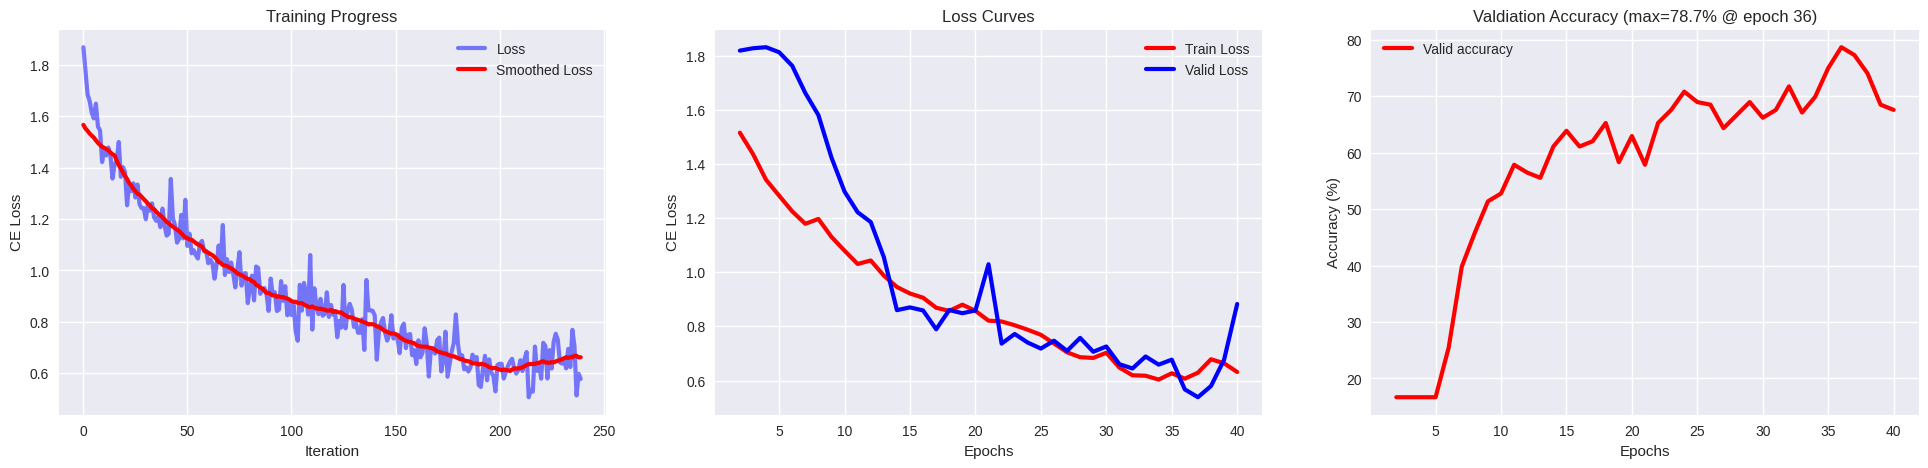

In [16]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()